In [1]:
import math
from time import perf_counter

from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm import tqdm

$$H = \sum_{i = 1}^n A_i \otimes S_i$$
![img](https://i.ibb.co/72fzdsb/phm-layer.png)

In [2]:
class PHMLinear(nn.Module):
    def __init__(self, in_features, out_features, n):
        super().__init__()
        assert in_features % n == 0 and out_features % n == 0

        self.A = nn.ParameterList()
        self.S = nn.ParameterList()
        for _ in range(n):
            A = torch.empty(n, n)
            nn.init.xavier_uniform_(A)
            self.A.append(nn.Parameter(A))

            S = torch.empty(in_features // n, out_features // n)
            nn.init.xavier_uniform_(S)
            self.S.append(nn.Parameter(S))
        
        bias = torch.empty(out_features)
        nn.init.uniform_(bias, -1 / math.sqrt(in_features), 1 / math.sqrt(in_features))
        self.bias = nn.Parameter(bias)
    
    def forward(self, x):
        '''
        x is of shape (bs, in_features)
        W is of shape (in_features, out_features)
        '''
        W = sum([torch.kron(A, S) for A, S in zip(self.A, self.S)])
        return x @ W + self.bias

In [3]:
BATCH_SIZE = 128

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])


def collator(objs):
    x, y = list(zip(*objs))
    return torch.stack(x, dim=0), torch.tensor(y)


train_ds = torchvision.datasets.MNIST('./mnist', train=True, transform=transforms, download=True)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                           shuffle=True, collate_fn=collator)

test_ds = torchvision.datasets.MNIST('./mnist', train=False, transform=transforms, download=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE,
                                          shuffle=False, collate_fn=collator)

In [4]:
def train_loop(model, num_epochs, verbose=True):
    opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    train_loss_log = [[] for _ in range(num_epochs)]
    train_acc_log = [[] for _ in range(num_epochs)]
    test_loss_log = [[] for _ in range(num_epochs)]
    test_acc_log = [[] for _ in range(num_epochs)]

    for i in range(num_epochs):
        model.train()
        # training
        for x, y in train_loader:
            output = model(x)
            L = F.cross_entropy(output, y)

            opt.zero_grad()
            L.backward()
            opt.step()

            L = L.item()
            train_loss_log[i].append(L)
            train_acc_log[i].append((output.argmax(dim=-1) == y).float().mean().item())
        if verbose:
            print(f'Epoch {i} train loss: {np.mean(train_loss_log[i])}')
            print(f'Epoch {i} train accuracy: {np.mean(train_acc_log[i])}')
        
        # validation
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                output = model(x)
                L = F.cross_entropy(output, y).item()
                test_loss_log[i].append(L)
                test_acc_log[i].append((output.argmax(dim=-1) == y).float().mean().item())
        if verbose:
            print(f'Epoch {i} validation loss: {np.mean(test_loss_log[i])}')
            print(f'Epoch {i} validation accuracy: {np.mean(test_acc_log[i])}')
            print('-' * 100)
    return train_loss_log, train_acc_log, test_loss_log, test_acc_log

$$\left\{A_i\right\}_{i = 1}^n; \,\,\, A_i \in \mathbb{R}^{n \times n}$$
$$\left\{S_i\right\}_{i = 1}^n; \,\,\, S_i \in \mathbb{R}^{\frac{in}{n} \times \frac{out}{n}}$$
![img](https://i.ibb.co/72fzdsb/phm-layer.png)

In [5]:
def count_parameters(model):
    return sum([p.numel() for p in model.parameters()])


def baseline():
    return nn.Sequential(
        nn.Flatten(start_dim=1),
        nn.Linear(784, 784),
        nn.ReLU(),
        nn.Linear(784, 10),
    )


def phm(n):
    return nn.Sequential(
        nn.Flatten(start_dim=1),
        PHMLinear(784, 784, n),
        nn.ReLU(),
        nn.Linear(784, 10)
    )


# phm layer is equivalent to nn.Linear if n = 1
print('Baseline parameters count: ', count_parameters(baseline()))
print('PHM baseline parameters count: ', count_parameters(phm(1)))

Baseline parameters count:  623290
PHM baseline parameters count:  623291


In [95]:
bs_train_loss, bs_train_acc, bs_val_loss, bs_val_acc = train_loop(baseline(), 10, verbose=False)

In [96]:
phm_train_loss, phm_train_acc, phm_val_loss, phm_val_acc = train_loop(phm(1), 10, verbose=False)

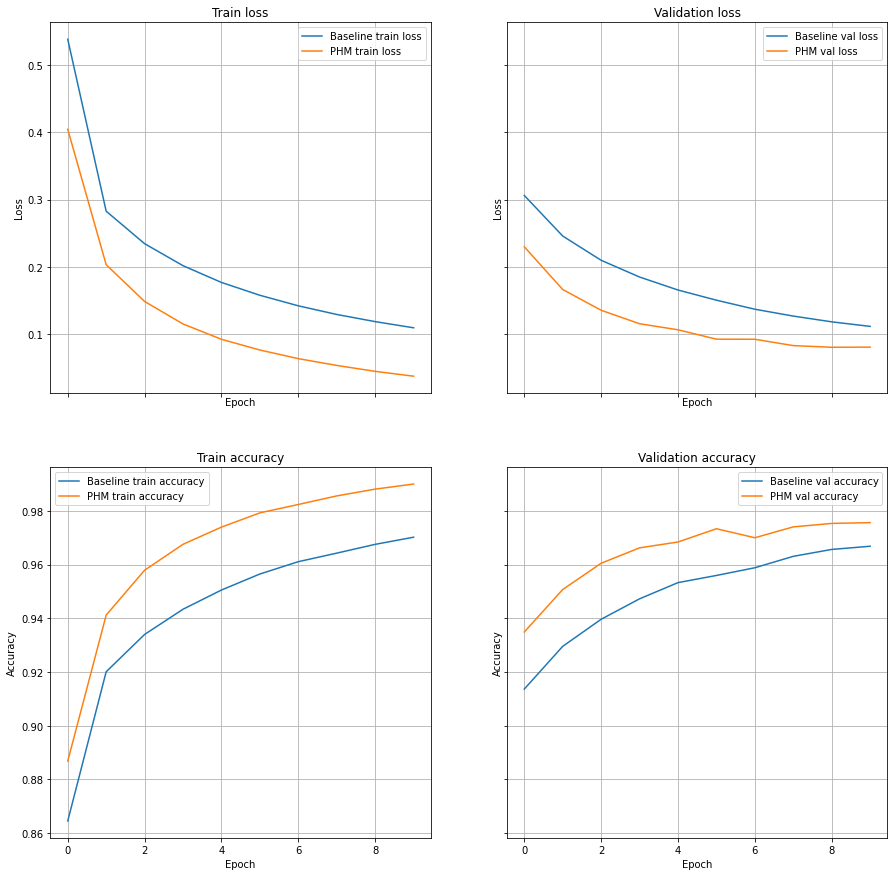

In [111]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15), sharey='row', sharex='all')

_ = ax1.set_title('Train loss')
_ = ax1.set_xlabel('Epoch')
_ = ax1.set_ylabel('Loss')
_ = ax1.plot(np.mean(bs_train_loss, axis=1), label='Baseline train loss')
_ = ax1.plot(np.mean(phm_train_loss, axis=1), label='PHM train loss')
_ = ax1.grid()
_ = ax1.legend()

_ = ax2.set_title('Validation loss')
_ = ax2.set_xlabel('Epoch')
_ = ax2.set_ylabel('Loss')
_ = ax2.plot(np.mean(bs_val_loss, axis=1), label='Baseline val loss')
_ = ax2.plot(np.mean(phm_val_loss, axis=1), label='PHM val loss')
_ = ax2.grid()
_ = ax2.legend()

_ = ax3.set_title('Train accuracy')
_ = ax3.set_xlabel('Epoch')
_ = ax3.set_ylabel('Accuracy')
_ = ax3.plot(np.mean(bs_train_acc, axis=1), label='Baseline train accuracy')
_ = ax3.plot(np.mean(phm_train_acc, axis=1), label='PHM train accuracy')
_ = ax3.grid()
_ = ax3.legend()

_ = ax4.set_title('Validation accuracy')
_ = ax4.set_xlabel('Epoch')
_ = ax4.set_ylabel('Accuracy')
_ = ax4.plot(np.mean(bs_val_acc, axis=1), label='Baseline val accuracy')
_ = ax4.plot(np.mean(phm_val_acc, axis=1), label='PHM val accuracy')
_ = ax4.grid()
_ = ax4.legend()

In [15]:
val_acc = []
times = []
for i in tqdm(range(5)):
    start = perf_counter()
    _, _, _, val_acc_history = train_loop(baseline(), 10, verbose=False)
    times.append(perf_counter() - start)
    val_acc.append(np.mean(val_acc_history[-1]))

In [ ]:
print('Baseline:')
print('Average time: ', np.mean(times), '; time std: ', np.std(times))
print('Average val accuracy: ', np.mean(val_acc), '; accuracy std: ', np.std(val_acc))

Baseline:
Average time:  55.45577243919979 ; time std:  1.1604662858372985
Average val accuracy:  0.9674248417721518 ; accuracy std:  0.0006695534367013717


In [ ]:
val_acc = []
times = []
for i in tqdm(range(5)):
    start = perf_counter()
    _, _, _, val_acc_history = train_loop(phm(1), 10, verbose=False)
    times.append(perf_counter() - start)
    val_acc.append(np.mean(val_acc_history[-1]))

100%|██████████| 5/5 [04:48<00:00, 57.64s/it]


In [ ]:
print('PHM(n = 1):')
print('Average time: ', np.mean(times), '; time std: ', np.std(times))
print('Average val accuracy: ', np.mean(val_acc), '; accuracy std: ', np.std(val_acc))

PHM(n = 1):
Average time:  57.63634769820055 ; time std:  2.2930127473406348
Average val accuracy:  0.9762856012658228 ; accuracy std:  0.001249962445357984


In [6]:
class Linear(nn.Module):
    def __init__(self, in_features, out_features, multiply=False):
        super().__init__()

        W = torch.empty(in_features, out_features)
        nn.init.xavier_uniform_(W)
        if multiply:
            s = torch.empty(1, 1)
            nn.init.xavier_uniform_(s)
            W *= s
        self.W = nn.Parameter(W)

        bias = torch.empty(out_features)
        nn.init.uniform_(bias, -1 / math.sqrt(in_features), 1 / math.sqrt(in_features))
        self.bias = nn.Parameter(bias)
    
    def forward(self, x):
        return x @ self.W + self.bias

In [7]:
def baseline_custom_linear(multiply=False):
    return nn.Sequential(
        nn.Flatten(start_dim=1),
        Linear(784, 784, multiply),
        nn.ReLU(),
        nn.Linear(784, 10),
    )

print(count_parameters(baseline_custom_linear()))

623290


In [125]:
val_acc = []
times = []
for i in tqdm(range(5)):
    start = perf_counter()
    _, _, _, val_acc_history = train_loop(baseline_custom_linear(False), 10, verbose=False)
    times.append(perf_counter() - start)
    val_acc.append(np.mean(val_acc_history[-1]))

100%|██████████| 5/5 [04:36<00:00, 55.37s/it]


In [126]:
print('Custom linear(multiply=False)')
print('Average time: ', np.mean(times), '; time std: ', np.std(times))
print('Average val accuracy: ', np.mean(val_acc), '; accuracy std: ', np.std(val_acc))

Custom linear(multiply=False)
Average time:  55.37226182159939 ; time std:  0.6042701159437096
Average val accuracy:  0.9674643987341772 ; accuracy std:  0.000476328899477562


In [131]:
val_acc = []
times = []
for i in tqdm(range(5)):
    start = perf_counter()
    _, _, _, val_acc_history = train_loop(baseline_custom_linear(True), 10, verbose=False)
    times.append(perf_counter() - start)
    val_acc.append(np.mean(val_acc_history[-1]))

100%|██████████| 5/5 [04:42<00:00, 56.55s/it]


In [132]:
print('Custom linear(multiply=True)')
print('Average time: ', np.mean(times), '; time std: ', np.std(times))
print('Average val accuracy: ', np.mean(val_acc), '; accuracy std: ', np.std(val_acc))

Custom linear(multiply=True)
Average time:  56.54839309980089 ; time std:  1.1132140076156982
Average val accuracy:  0.968334651898734 ; accuracy std:  0.0010695020438762576


![](https://dustinstansbury.github.io/theclevermachine/assets/images/svd-data-compression/low-rank-approximation.png)

In [8]:
def low_rank(r):
    return nn.Sequential(
        nn.Flatten(start_dim=1),
        nn.Linear(784, r, bias=False),
        nn.Linear(r, 784),
        nn.ReLU(),
        nn.Linear(784, 10),
    )

$$count(PHM) = n^3 + \frac{in\cdot out}{n}$$

In [9]:
configs = {
    f'baseline': lambda: baseline(),
    f'low rank {784 // 4}': lambda: low_rank(784 // 4),
    f'low rank {784 // 8}': lambda: low_rank(784 // 8),
    f'low rank {784 // 14}': lambda: low_rank(784 // 14),
    f'low rank {784 // 28}': lambda: low_rank(784 // 28),
    f'PHM(n=1)': lambda: phm(1),
    f'PHM(n=2)': lambda: phm(2),
    f'PHM(n=4)': lambda: phm(4),
    f'PHM(n=7)': lambda: phm(7),
    f'PHM(n=14)': lambda: phm(14),
}

In [10]:
for name, factory in configs.items():
    print(name, ' parameter count: ', count_parameters(factory()))

baseline  parameter count:  623290
low rank 196  parameter count:  315962
low rank 98  parameter count:  162298
low rank 56  parameter count:  96442
low rank 28  parameter count:  52538
PHM(n=1)  parameter count:  623291
PHM(n=2)  parameter count:  315970
PHM(n=4)  parameter count:  162362
PHM(n=7)  parameter count:  96785
PHM(n=14)  parameter count:  55282


In [16]:
def mean_val_acc(factory, n_repeats=5):
    val_acc = []
    for i in range(n_repeats):
        _, _, _, val_acc_history = train_loop(factory(), 10, verbose=False)
        val_acc.append(np.mean(val_acc_history[-1]))
    return np.mean(val_acc)

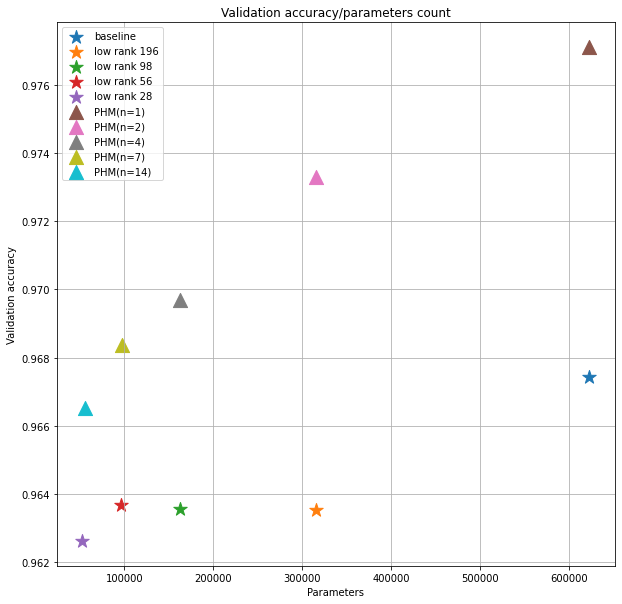

In [21]:
_ = plt.figure(figsize=(10, 10))
for name, factory in configs.items():
    marker = '^' if name.startswith('PHM') else '*'
    _ = plt.scatter([count_parameters(factory())], [mean_val_acc(factory)], s=200, marker=marker, label=name)
_ = plt.title('Validation accuracy/parameters count')
_ = plt.xlabel('Parameters')
_ = plt.ylabel('Validation accuracy')
_ = plt.grid()
_ = plt.legend()